In [1]:
# --- Celda 1: Importaciones y Configuración para el proyecto FDM ---

import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

print("--- LIBRERÍAS IMPORTADAS Y CONFIGURACIÓN PARA FDM CARGADA ---")

# --- PARÁMETROS DEL EXPERIMENTO (¡MODIFICA ESTOS VALORES!) ---

# Directorio donde se encuentran los ejecutables compilados de FDM
EXECUTABLE_DIR_FDM = './bin'

# Archivo donde se guardarán los resultados del benchmark
OUTPUT_FILE_FDM = 'resultados_fdm.csv'

# 1. TAMAÑOS DE MALLA A PROBAR (Divisiones en el eje M)
MESH_SIZES_FDM = [10, 50, 100] 

# 2. HILOS A PROBAR
THREAD_COUNTS_FDM = [1, 2, 4, 8, 16]

# Casos del problema a ejecutar (este proyecto tiene 4 casos)
CASES_FDM = [1, 2] 

# Lista de todas las versiones que se probarán para rendimiento
VERSIONS_FDM = [
    "poisson_serial",
    "poisson_parallel",
    "poisson_collapse",
    "poisson_sections",
    "poisson_sincronizacion",
    "poisson_schedule"
]

print("\n--- Configuración Actual para FDM ---")
print(f"Directorio de ejecutables: '{EXECUTABLE_DIR_FDM}'")
print(f"Archivo de salida: '{OUTPUT_FILE_FDM}'")
print(f"Mallas a probar (M x M): {MESH_SIZES_FDM}")
print(f"Hilos a probar: {THREAD_COUNTS_FDM}")
print(f"Versiones a testear: {VERSIONS_FDM}")

--- LIBRERÍAS IMPORTADAS Y CONFIGURACIÓN PARA FDM CARGADA ---

--- Configuración Actual para FDM ---
Directorio de ejecutables: './bin'
Archivo de salida: 'resultados_fdm.csv'
Mallas a probar (M x M): [10, 50, 100]
Hilos a probar: [1, 2, 4, 8, 16]
Versiones a testear: ['poisson_serial', 'poisson_parallel', 'poisson_collapse', 'poisson_sections', 'poisson_sincronizacion', 'poisson_schedule']


In [2]:
# --- Celda 2: Ejecución del Benchmark de Rendimiento (FDM) ---

print(f"--- INICIANDO BENCHMARK DE RENDIMIENTO PARA FDM ---")
print(f"Los resultados se guardarán en: {OUTPUT_FILE_FDM}")

try:
    with open(OUTPUT_FILE_FDM, 'w') as f:
        f.write("version,malla_M,malla_N,hilos,caso,schedule,tiempo\n")
        
        # Usamos una lista para mostrar el progreso
        tasks = []
        for version in VERSIONS_FDM:
            for m in MESH_SIZES_FDM:
                for case_id in CASES_FDM:
                    if version == "poisson_schedule":
                        for threads in THREAD_COUNTS_FDM:
                            for sched_type in [1, 2]:
                                tasks.append((version, m, case_id, threads, sched_type))
                    else:
                        threads_to_run = [1] if version == "poisson_serial" else THREAD_COUNTS_FDM
                        for threads in threads_to_run:
                            tasks.append((version, m, case_id, threads, None))

        for task in tqdm(tasks, desc="Ejecutando Benchmarks FDM"):
            version, m, case_id, threads, sched_type = task
            n = m
            
            if version == "poisson_schedule":
                sched_name = "static" if sched_type == 1 else "dynamic"
                cmd = [os.path.join(EXECUTABLE_DIR_FDM, version), str(m), str(n), str(threads), str(case_id), str(sched_type)]
                result = subprocess.run(cmd, capture_output=True, text=True, check=True)
                # La salida del C++ es M,N,hilos,schedule,tiempo
                time_val = result.stdout.strip().split(',')[-1]
                f.write(f"{version},{m},{n},{threads},{case_id},{sched_name},{time_val}\n")
            else:
                cmd = [os.path.join(EXECUTABLE_DIR_FDM, version), str(m), str(n), str(threads), str(case_id)]
                result = subprocess.run(cmd, capture_output=True, text=True, check=True)
                # La salida del C++ es M,N,hilos,tiempo
                time_val = result.stdout.strip().split(',')[-1]
                f.write(f"{version},{m},{n},{threads},{case_id},N/A,{time_val}\n")

    print("\n[+] BENCHMARK DE FDM FINALIZADO.")

except Exception as e:
    print(f"\nOcurrió un error durante el benchmark: {e}")

--- INICIANDO BENCHMARK DE RENDIMIENTO PARA FDM ---
Los resultados se guardarán en: resultados_fdm.csv


Ejecutando Benchmarks FDM: 100%|██████████████| 186/186 [02:15<00:00,  1.37it/s]


[+] BENCHMARK DE FDM FINALIZADO.


--- GENERANDO GRÁFICAS DE RENDIMIENTO PARA FDM ---
Datos de FDM cargados con éxito. 186 filas de resultados.


/tmp/ipykernel_4833/364876941.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['etiqueta'] = df_plot['version'] + df_plot['schedule'].apply(lambda x: f' ({x})' if pd.notna(x) else '')


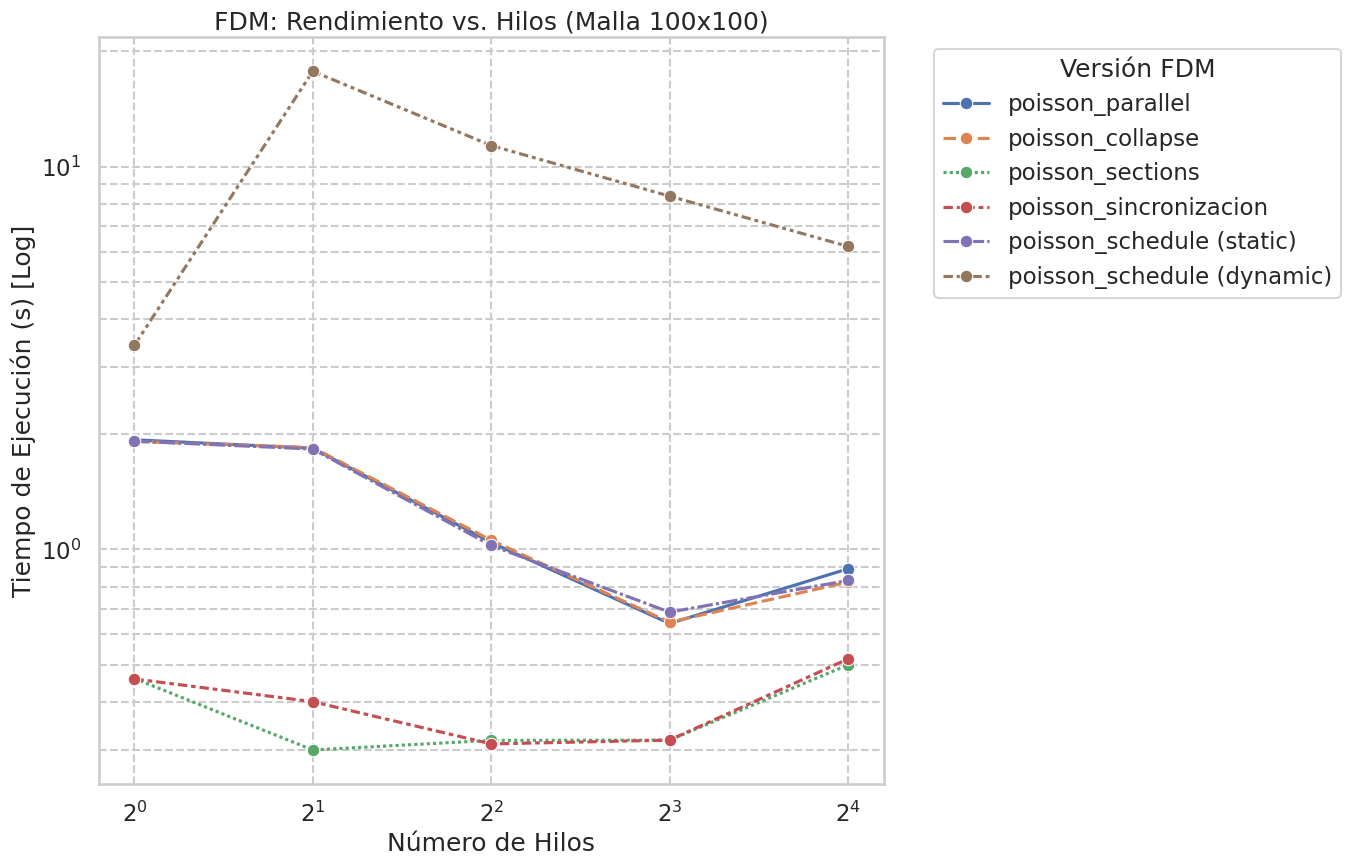

/tmp/ipykernel_4833/364876941.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_malla['etiqueta'] = df_plot_malla['version'] + df_plot_malla['schedule'].apply(lambda x: f' ({x})' if pd.notna(x) else '')


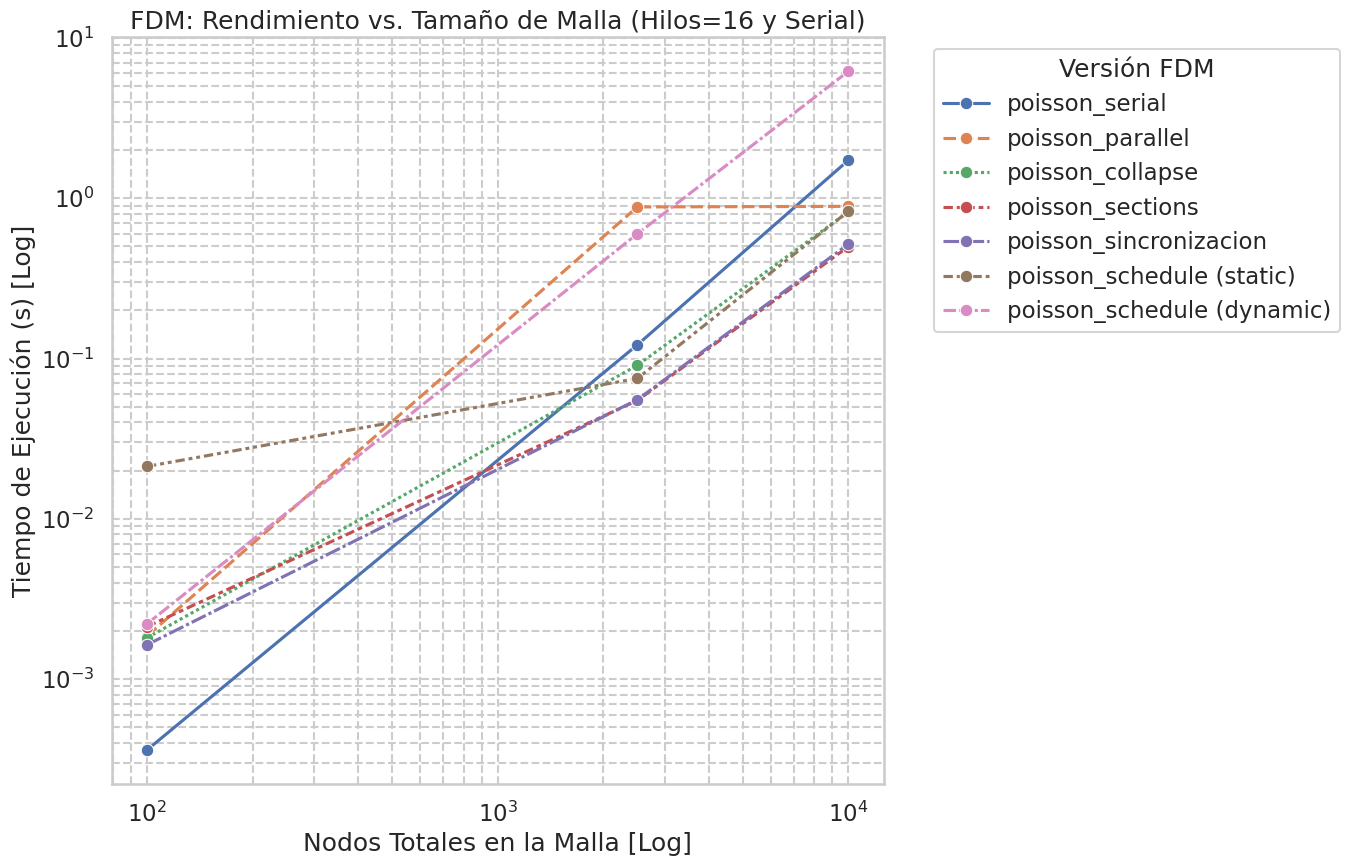

In [3]:
# --- Celda 3: Carga y Gráficas de Rendimiento (FDM) ---

print("--- GENERANDO GRÁFICAS DE RENDIMIENTO PARA FDM ---")

try:
    df_fdm = pd.read_csv(OUTPUT_FILE_FDM)
    df_fdm['malla_total'] = df_fdm['malla_M'] * df_fdm['malla_M']
    print(f"Datos de FDM cargados con éxito. {len(df_fdm)} filas de resultados.")
    
    sns.set_theme(style="whitegrid", context="talk")

    # --- GRÁFICA: HILOS vs TIEMPO (FDM) ---
    largest_mesh_m = df_fdm['malla_M'].max()
    df_plot = df_fdm[(df_fdm['malla_M'] == largest_mesh_m) & (df_fdm['caso'] == 1)]
    df_plot['etiqueta'] = df_plot['version'] + df_plot['schedule'].apply(lambda x: f' ({x})' if pd.notna(x) else '')
    
    plt.figure(figsize=(14, 9))
    sns.lineplot(data=df_plot[df_plot['version'] != 'poisson_serial'], x='hilos', y='tiempo', hue='etiqueta', style='etiqueta', marker='o')
    plt.title(f'FDM: Rendimiento vs. Hilos (Malla {largest_mesh_m}x{largest_mesh_m})')
    plt.xlabel('Número de Hilos'); plt.ylabel('Tiempo de Ejecución (s) [Log]')
    plt.xscale('log', base=2); plt.yscale('log')
    plt.xticks(THREAD_COUNTS_FDM)
    plt.legend(title='Versión FDM', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

    # --- GRÁFICA: MALLA vs TIEMPO (FDM) ---
    max_hilos = df_fdm['hilos'].max()
    df_plot_malla = df_fdm[((df_fdm['hilos'] == max_hilos) | (df_fdm['version'] == 'poisson_serial')) & (df_fdm['caso'] == 1)]
    df_plot_malla['etiqueta'] = df_plot_malla['version'] + df_plot_malla['schedule'].apply(lambda x: f' ({x})' if pd.notna(x) else '')

    plt.figure(figsize=(14, 9))
    sns.lineplot(data=df_plot_malla, x='malla_total', y='tiempo', hue='etiqueta', style='etiqueta', marker='o')
    plt.title(f'FDM: Rendimiento vs. Tamaño de Malla (Hilos={max_hilos} y Serial)')
    plt.xlabel('Nodos Totales en la Malla [Log]'); plt.ylabel('Tiempo de Ejecución (s) [Log]')
    plt.xscale('log'); plt.yscale('log')
    plt.legend(title='Versión FDM', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo '{OUTPUT_FILE_FDM}'. Asegúrate de que la Celda 2 se haya ejecutado.")

In [4]:
# --- Celda 4: Función de Visualización Universal para FDM ---

print("--- FUNCIÓN DE VISUALIZACIÓN PARA FDM LISTA ---")

def plot_fdm_solution(version_name, case_id, mesh_size_m, mesh_size_n, threads=8, schedule_type=None):
    sched_name = ""
    if schedule_type:
        sched_name = " (static)" if schedule_type == 1 else " (dynamic)"
    print(f"\nCalculando solución FDM para: '{version_name}{sched_name}' - Caso {case_id}")
    
    cmd = [os.path.join(EXECUTABLE_DIR_FDM, version_name), str(mesh_size_m), str(mesh_size_n), str(threads), str(case_id)]
    if schedule_type:
        cmd.append(str(schedule_type))
    cmd.extend(['--mode', 'solution'])
    
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, check=True, timeout=180)
        df_solution = pd.read_csv(io.StringIO(result.stdout))
        
        # Reorganizar datos para plot_surface
        X = df_solution['x'].values.reshape((mesh_size_n + 1, mesh_size_m + 1))
        Y = df_solution['y'].values.reshape((mesh_size_n + 1, mesh_size_m + 1))
        V_grid = df_solution['V'].values.reshape((mesh_size_n + 1, mesh_size_m + 1))
        
        fig = plt.figure(figsize=(11, 7))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, V_grid, cmap=cm.viridis, rstride=1, cstride=1, linewidth=0, antialiased=True)
        ax.set_title(f'Solución FDM: {version_name}{sched_name} - Caso {case_id}', fontsize=16)
        ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('V(x,y)')
        ax.view_init(elev=30, azim=-60)
        fig.colorbar(surf, shrink=0.6, aspect=10, label='Potencial V(x,y)')
        plt.show()
        
    except Exception as e:
        print(f"Ocurrió un error al ejecutar o graficar {' '.join(cmd)}: {e}")

--- FUNCIÓN DE VISUALIZACIÓN PARA FDM LISTA ---


--- GENERANDO GRÁFICAS DE VALIDACIÓN PARA CADA IMPLEMENTACIÓN DE FDM ---

  VALIDACIÓN VISUAL DE FDM PARA EL CASO 1

Calculando solución FDM para: 'poisson_serial' - Caso 1


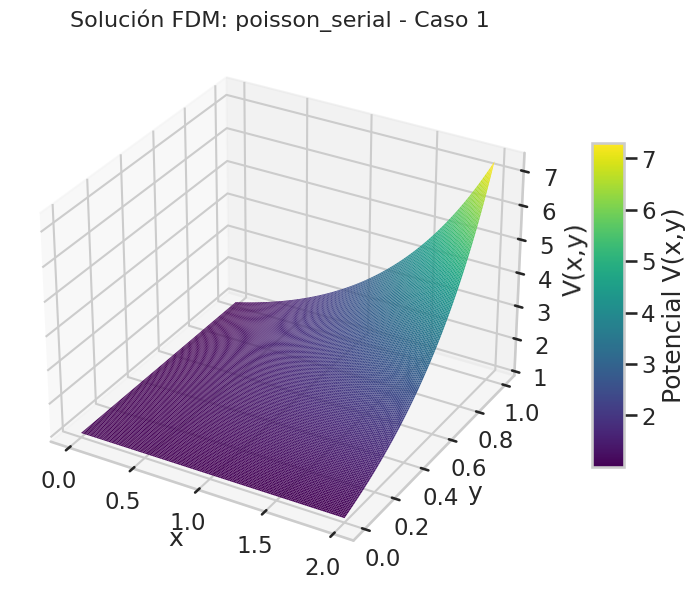


Calculando solución FDM para: 'poisson_parallel' - Caso 1


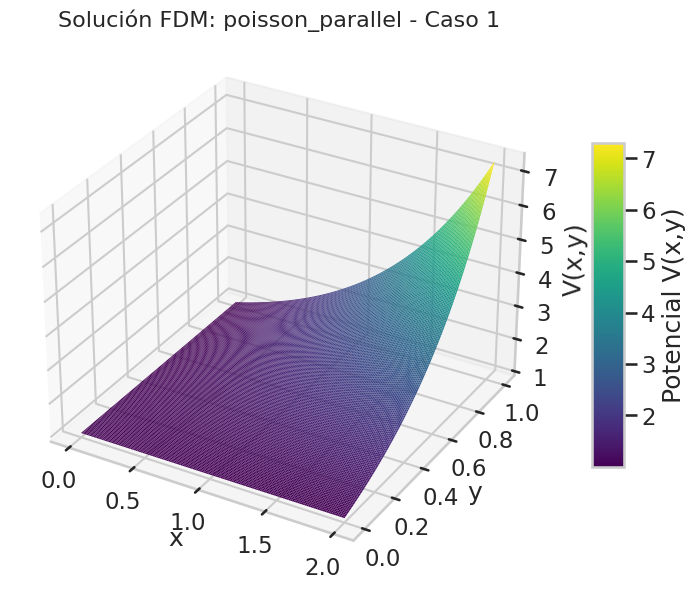


Calculando solución FDM para: 'poisson_collapse' - Caso 1


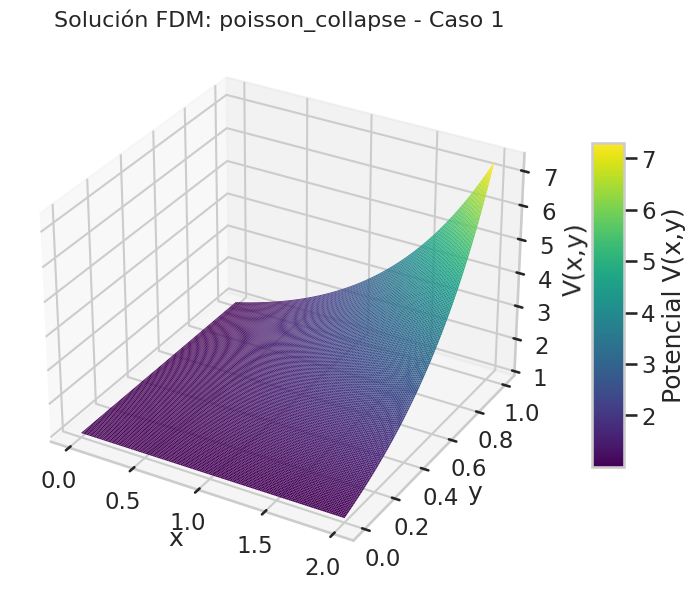


Calculando solución FDM para: 'poisson_sections' - Caso 1


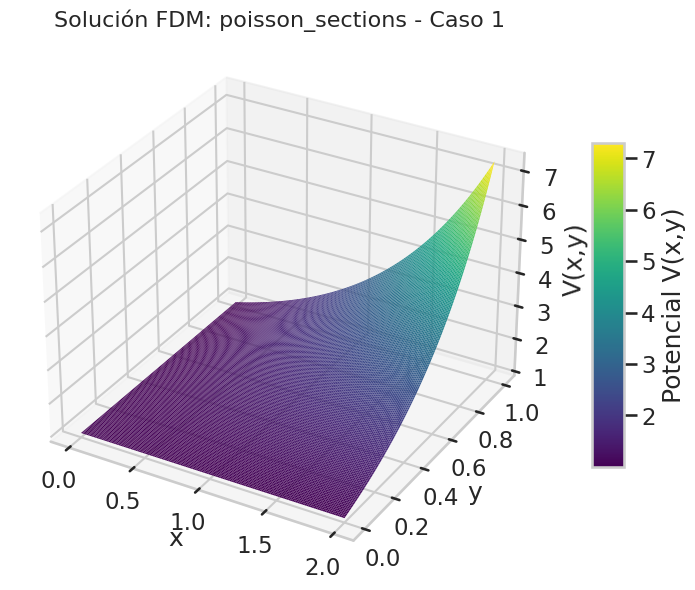


Calculando solución FDM para: 'poisson_sincronizacion' - Caso 1


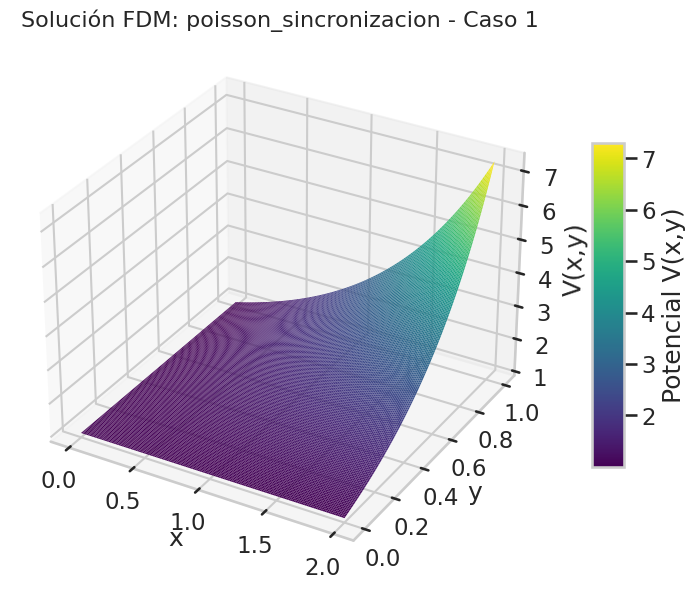


Calculando solución FDM para: 'poisson_schedule (static)' - Caso 1


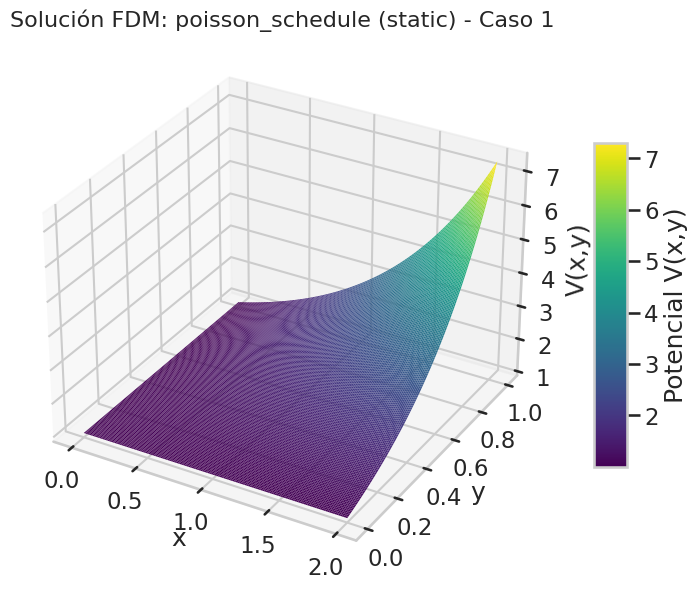


Calculando solución FDM para: 'poisson_schedule (dynamic)' - Caso 1


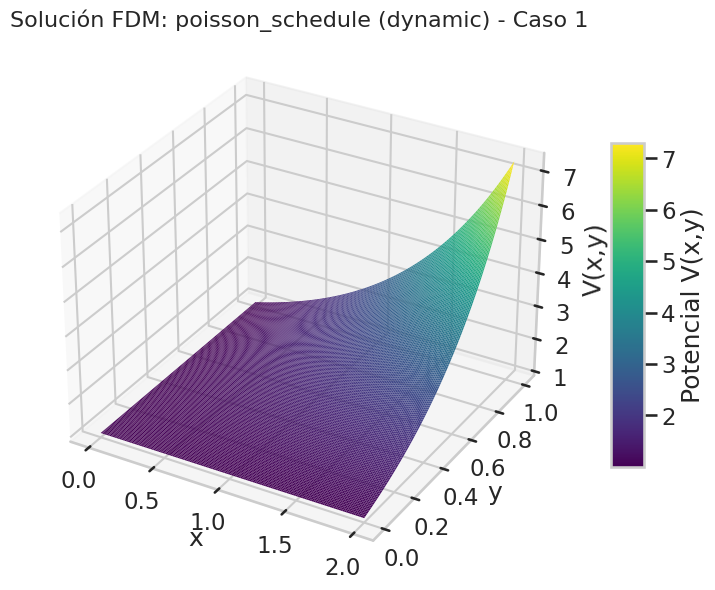


  VALIDACIÓN VISUAL DE FDM PARA EL CASO 2

Calculando solución FDM para: 'poisson_serial' - Caso 2


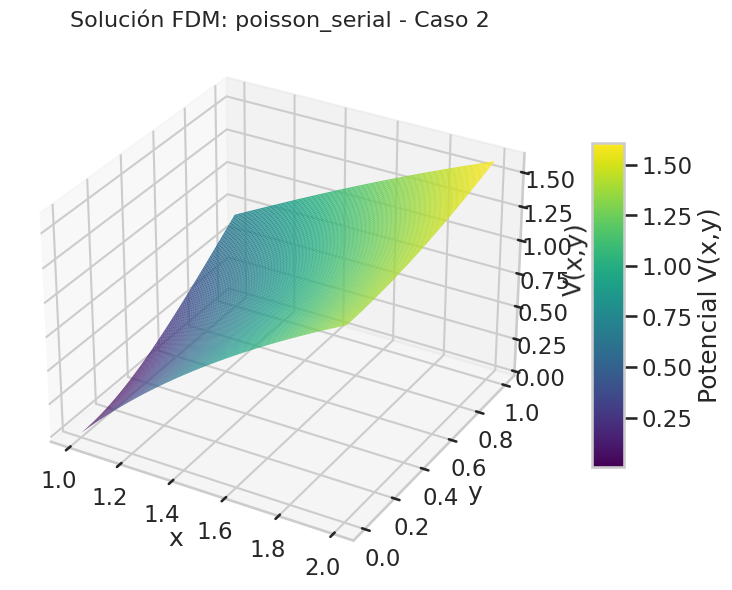


Calculando solución FDM para: 'poisson_parallel' - Caso 2


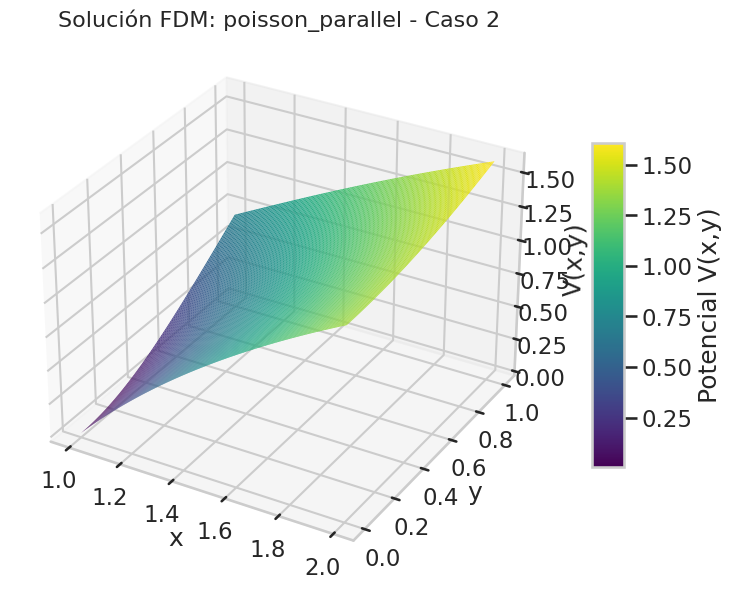


Calculando solución FDM para: 'poisson_collapse' - Caso 2


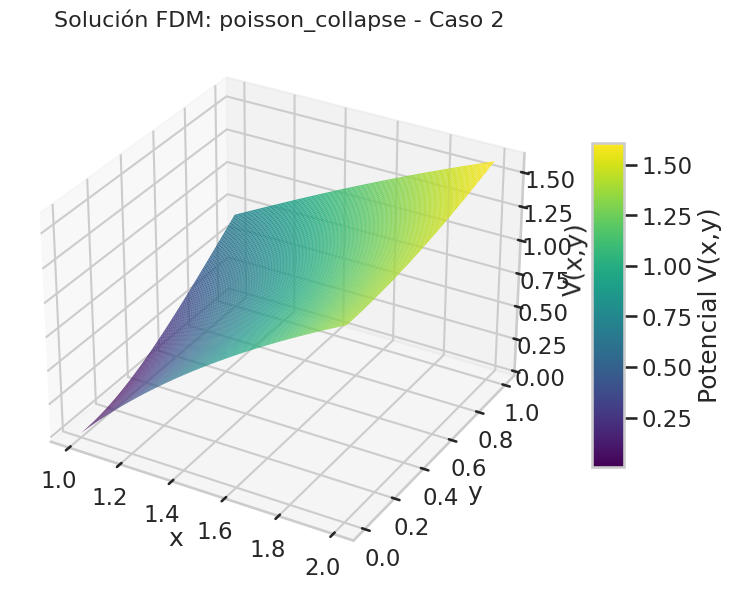


Calculando solución FDM para: 'poisson_sections' - Caso 2


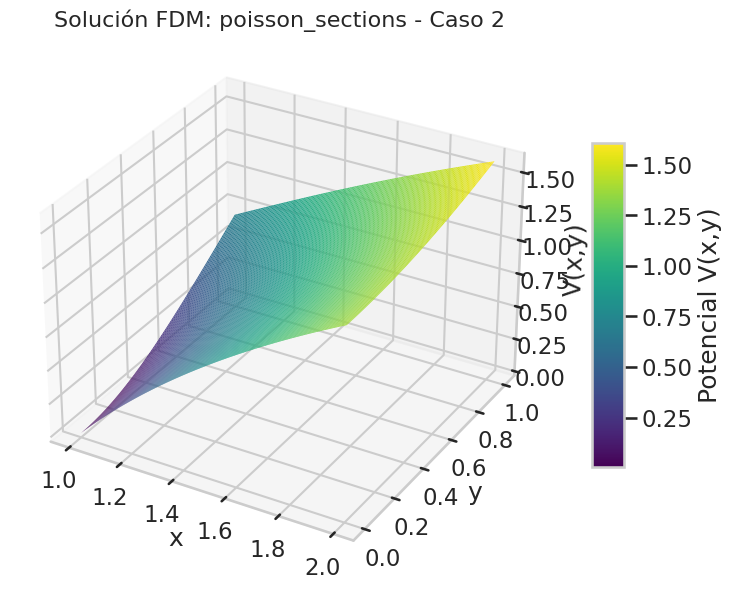


Calculando solución FDM para: 'poisson_sincronizacion' - Caso 2


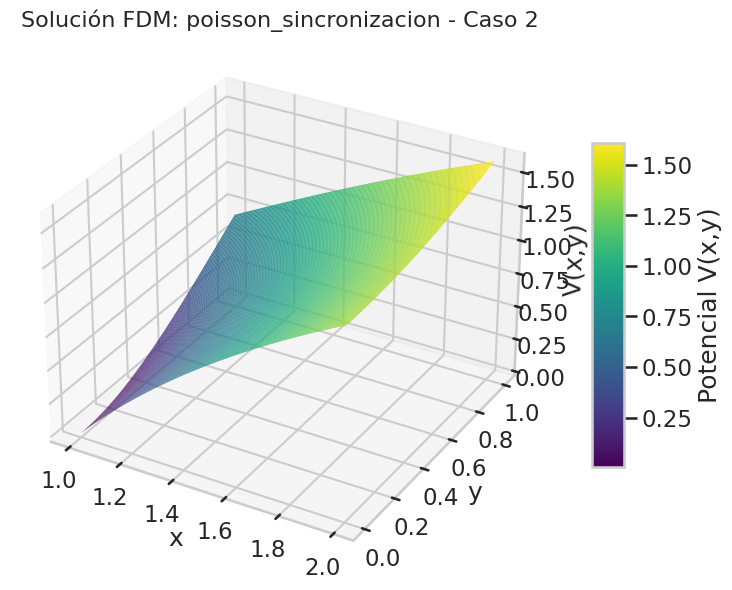


Calculando solución FDM para: 'poisson_schedule (static)' - Caso 2


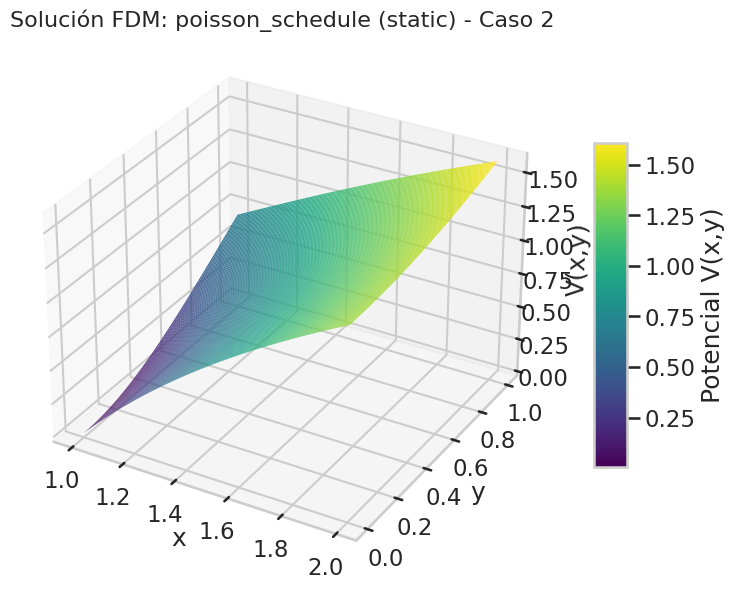


Calculando solución FDM para: 'poisson_schedule (dynamic)' - Caso 2


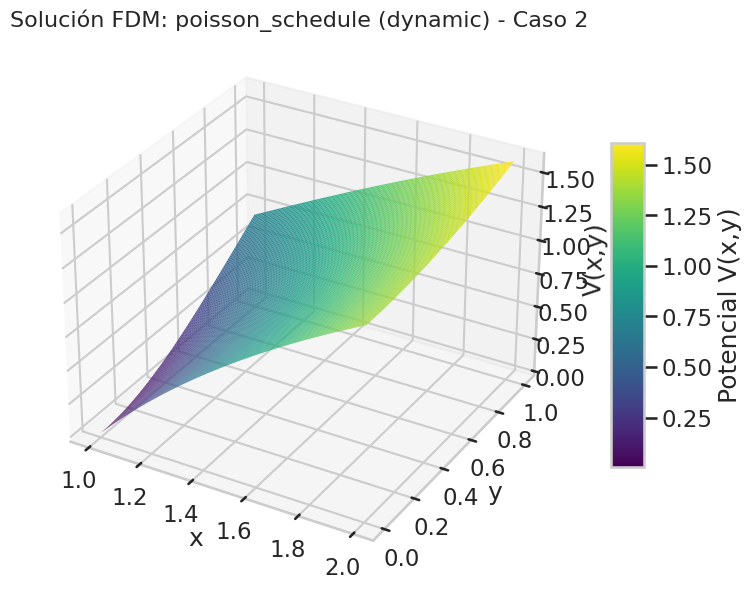

In [6]:
# --- Celda 5: Validación Visual de Todas las Implementaciones de FDM ---

print("--- GENERANDO GRÁFICAS DE VALIDACIÓN PARA CADA IMPLEMENTACIÓN DE FDM ---")

MESH_VISUALIZACION = 150 
THREADS_VISUALIZACION = max(THREAD_COUNTS_FDM)

for case_to_plot in CASES_FDM:
    print("\n" + "="*60)
    print(f"  VALIDACIÓN VISUAL DE FDM PARA EL CASO {case_to_plot}")
    print("="*60)
    
    for version in VERSIONS_FDM:
        if version == "poisson_schedule":
            plot_fdm_solution(version, case_id=case_to_plot, mesh_size_m=MESH_VISUALIZACION, mesh_size_n=MESH_VISUALIZACION,
                              threads=THREADS_VISUALIZACION, schedule_type=1) # Static
            plot_fdm_solution(version, case_id=case_to_plot, mesh_size_m=MESH_VISUALIZACION, mesh_size_n=MESH_VISUALIZACION,
                              threads=THREADS_VISUALIZACION, schedule_type=2) # Dynamic
        elif version == "poisson_serial":
            plot_fdm_solution(version, case_id=case_to_plot, mesh_size_m=MESH_VISUALIZACION, mesh_size_n=MESH_VISUALIZACION,
                              threads=1)
        else:
            plot_fdm_solution(version, case_id=case_to_plot, mesh_size_m=MESH_VISUALIZACION, mesh_size_n=MESH_VISUALIZACION,
                              threads=THREADS_VISUALIZACION)